In [1]:
import torch
import torchvision
from torch import nn
from tqdm import tqdm

from mmpretrain.registry import MODELS
from torchvision.datasets import STL10, CIFAR10
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from pathlib import Path

import matplotlib.pyplot as plt

DATA_PATH_STL10 = Path("./") / "data" / "datasets" / "stl10"
DATA_PATH_CIFAR10 = Path("./") / "data" / "datasets" / "cifar10"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

basic_transforms = v2.Compose(
    [
        v2.Resize(96),
        v2.ToTensor(),
        v2.Normalize(
            mean=[0.4467, 0.4398, 0.4066],
            std=[0.2242, 0.2215, 0.2239],
        )
    ]
)

checkpoints = [
    # "saved/alpha25_checkpoint-epoch50.pth",
    # "saved/alpha5_checkpoint-epoch50.pth",
    "saved/alpha75_checkpoint-epoch50.pth",
    # "saved/simclr_checkpoint-epoch80.pth",
]

c:\Users\ryabo\AppData\Local\Programs\Python\Python310\lib\site-packages\onnxscript\converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ryabo\AppData\Local\Programs\Python\Python310\lib\site-packages\onnxscript\converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ryabo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [2]:
class BackBone(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = MODELS.build(
            dict(
                type="VisionTransformer",
                arch="small",
                img_size=96,
                patch_size=8,
                out_type="cls_token",
            )
        )
        self.backbone.eval()
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def forward(self, x: torch.Tensor):
        """
        x : tensor of shape (B, C, H, W)
        """
        return self.backbone(x)[0]
    

def load_backbone(path):
    model = BackBone()
    checkpoint = torch.load(path)
    if checkpoint.get("state_dict_backbone") is not None:
        model.backbone.load_state_dict(checkpoint["state_dict_backbone"]) 
    else:
        raise RuntimeError
    return model

In [ ]:
def get_representations(model, x):
    return model(x)


def extract_features(model, dataloader, limit = 100):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for step, (imgs, labels) in enumerate(tqdm(dataloader, total=min(limit, len(dataloader)))):
            if step >= limit:
                break
            imgs = imgs.to(DEVICE)
            feats = get_representations(model, imgs) 
            features_list.append(feats.cpu())
            labels_list.append(labels)
    features = torch.cat(features_list)
    labels = torch.cat(labels_list)
    return features, labels
from sklearn.manifold import TSNE


def get_tsne_from_backbone(checkpoint_path, train_data, test_data, dataset_type="STL10"):

    model = load_backbone(checkpoint_path).to(DEVICE)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    # объединяем
    train_features, train_labels = extract_features(model, train_loader)
    test_features, test_labels = extract_features(model, test_loader)

    X_train = train_features.numpy()
    y_train = train_labels.numpy()
    X_test = test_features.numpy()
    y_test = test_labels.numpy()

    tsne = TSNE(random_state=1984, verbose=0)

    X_train_2d = tsne.fit_transform(X_train)
    X_test_2d = tsne.fit_transform(X_test)


    def plot_tsne(X_2d, y, ax, title):
        if dataset_type == "STL10":
            classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
        else:
            classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        palette = [
            "red",
            "blue",
            "green",
            "orange",
            "purple",
            "brown",
            "grey",
            "lime",
            "cyan",
            "yellow"
        ]
        for i in range(10):
            idx = y == i
            ax.scatter(X_2d[idx,0], X_2d[idx,1], c=palette[i], label=classes[i], s=10, alpha=0.7)
        ax.set_title(title)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(checkpoint_path)

    plot_tsne(X_train_2d, y_train, axes[0], f"{dataset_type} t-SNE Train")
    plot_tsne(X_test_2d, y_test, axes[1], f"{dataset_type} t-SNE Test")

    plt.legend()
    plt.tight_layout()
    plt.show()


Files already downloaded and verified
Files already downloaded and verified
STL10 T-SNE for: saved/alpha75_checkpoint-epoch50.pth


c:\Users\ryabo\AppData\Local\Programs\Python\Python310\lib\site-packages\mmcv\cnn\bricks\transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv`` rather than ``mmcv-lite`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
  0%|          | 0/79 [00:00<?, ?it/s]c:\Users\ryabo\AppData\Local\Programs\Python\Python310\lib\site-packages\mmpretrain\models\utils\attention.py:594: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = self.scaled_dot_product_attention(q, k, v, dropout_p=attn_drop)
100%|██████████| 125/125 [00:15<00:00,  7.97it/s]


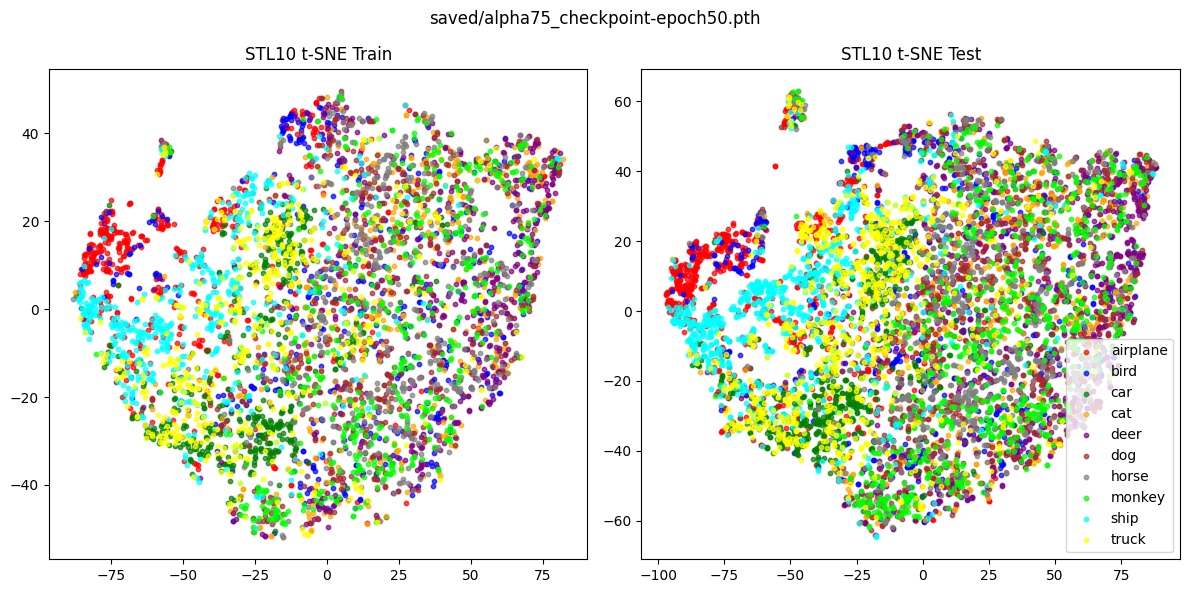

In [4]:
dataset_type = "STL10"
train_data = STL10(root=DATA_PATH_STL10, split='train', transform=basic_transforms, download=True)
test_data = STL10(root=DATA_PATH_STL10, split='test', transform=basic_transforms, download=True)

for checkpoint_path in checkpoints:
    print(f"{dataset_type} T-SNE for: {checkpoint_path}")
    get_tsne_from_backbone(
        checkpoint_path=checkpoint_path,
        train_data=train_data,
        test_data=test_data,
        dataset_type=dataset_type
    )

100%|██████████| 170498071/170498071 [00:11<00:00, 15319718.59it/s]


Extracting data\datasets\cifar10\cifar-10-python.tar.gz to data\datasets\cifar10
Files already downloaded and verified
CIFAR10 T-SNE for: saved/alpha75_checkpoint-epoch50.pth


100%|██████████| 157/157 [00:19<00:00,  7.90it/s]


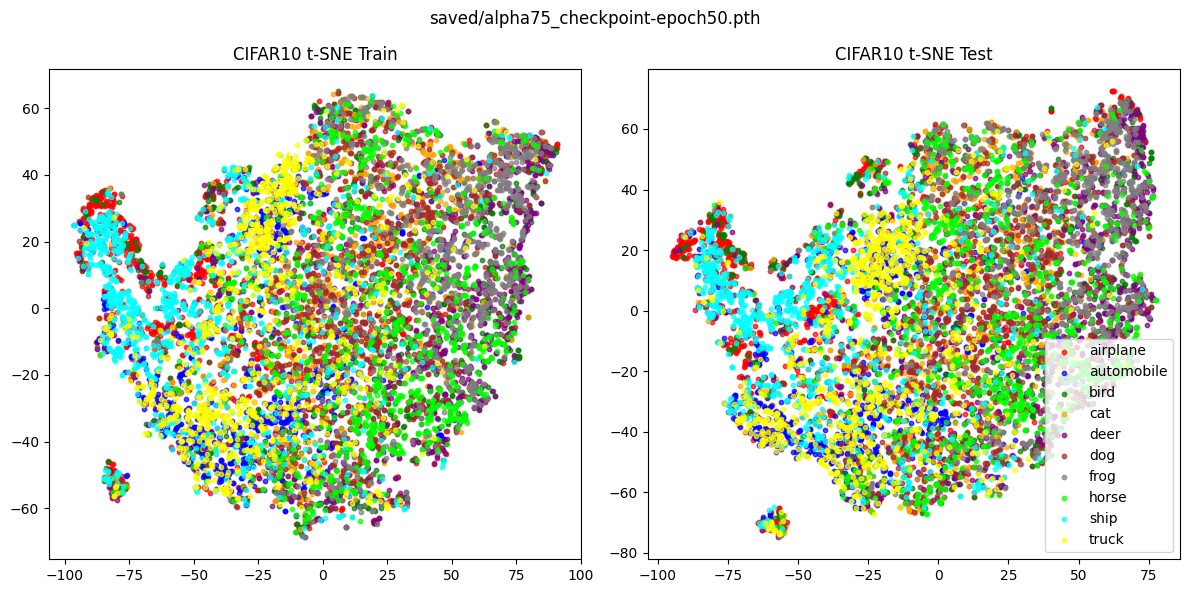

In [5]:
dataset_type = "CIFAR10"
train_data = CIFAR10(root=DATA_PATH_CIFAR10, train=True, transform=basic_transforms, download=True)
test_data = CIFAR10(root=DATA_PATH_CIFAR10, train=False, transform=basic_transforms, download=True)

for checkpoint_path in checkpoints:
    print(f"{dataset_type} T-SNE for: {checkpoint_path}")
    get_tsne_from_backbone(
        checkpoint_path=checkpoint_path,
        train_data=train_data,
        test_data=test_data,
        dataset_type=dataset_type
    )